In [35]:
import pandas as pd

In [36]:
train = pd.read_csv('../data/gridloss/train.csv')
train['time'] = pd.to_datetime(train['Unnamed: 0'])

In [37]:
train = train[['time', 'grid1-load', 'grid1-loss', 'grid1-temp']]

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   time        17520 non-null  datetime64[ns]
 1   grid1-load  17520 non-null  float64       
 2   grid1-loss  17519 non-null  float64       
 3   grid1-temp  17518 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 547.6 KB


In [39]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
class NN(nn.Module):
    def __init__(self, input_size, output_size, learning_rate):
        """
        Define the layers of the neural network.

        Parameters:
            input_size: int
                The size of the input, in this case 784 (28 x 28).
            num_classes: int
                The number of classes we want to predict, in our case 10 (digits 0 to 9).
        """
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, output_size)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        self.loss = nn.L1Loss()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        """
        Define the forward pass of the neural network.

        Parameters:
            x: torch.Tensor
                The input tensor.

        Returns:
            torch.Tensor
                The output tensor after passing through the network.
        """
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def train_model(self, X, y, batch_size, num_epochs, learning_rate):
        # Convert data to PyTorch tensors
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(self.device)

        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        loss_history = []

        for epoch in tqdm(range(num_epochs)):
            self.train()
            running_loss = 0.0

            for inputs, targets in dataloader:
                # Zero the gradients
                self.optimizer.zero_grad()

                # Forward pass
                outputs = self(inputs)

                # Compute loss
                loss = self.loss(outputs, targets)

                # Backward pass and optimization
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            # Compute average loss for the epoch
            epoch_loss = running_loss / len(dataloader.dataset)
            loss_history.append(epoch_loss)

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        return loss_history

In [41]:
input_size = 72  # 3 time series x24 hours pixels
forecast_horizon = 24  # 24 hours into future
learning_rate = 0.001
batch_size = 12
num_epochs = 10

In [42]:
model = NN(input_size=input_size, output_size=forecast_horizon, learning_rate=0.001)

In [43]:
def create_training_windows(df: pd.DataFrame, input_cols: list, target_col: str, window_size: int, forecast_horizon: int):
    df = df.dropna().reset_index(drop=True)

    num_samples = len(df) - window_size - forecast_horizon + 1
    if num_samples <= 0:
        raise ValueError("Not enough data to create windows.")

    # Initialize lists to hold the input-output pairs
    X, y = [], []

    for i in range(num_samples):
        # Select input window
        input_window = df.loc[i:i + window_size - 1, input_cols].values.flatten()
        
        # Select target window (forecast horizon)
        target_window = df.loc[i + window_size:i + window_size + forecast_horizon - 1, target_col].values
        
        X.append(input_window)
        y.append(target_window)

    return np.array(X), np.array(y)


In [44]:
# Define input and target columns
input_columns = ["grid1-load", "grid1-loss", "grid1-temp"]
target_column = "grid1-loss"
window_size = 24

X, y = create_training_windows(train, input_columns, target_column, window_size, forecast_horizon)

print("X shape:", X.shape)  # Should be (num_samples, window_size * 3)
print("y shape:", y.shape)  # Should be (num_samples, forecast_horizon)

X shape: (17471, 72)
y shape: (17471, 24)


In [45]:
loss_history = model.train_model(X, y, batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate)

  2%|▏         | 10/500 [00:02<02:06,  3.88it/s]

Epoch [10/500], Loss: 1.9471


  4%|▍         | 20/500 [00:05<02:04,  3.85it/s]

Epoch [20/500], Loss: 1.8788


  6%|▌         | 30/500 [00:07<02:07,  3.69it/s]

Epoch [30/500], Loss: 1.8467


  8%|▊         | 40/500 [00:10<02:04,  3.68it/s]

Epoch [40/500], Loss: 1.8335


 10%|█         | 50/500 [00:13<01:59,  3.76it/s]

Epoch [50/500], Loss: 1.8173


 12%|█▏        | 60/500 [00:16<02:03,  3.55it/s]

Epoch [60/500], Loss: 1.7914


 14%|█▍        | 70/500 [00:18<01:57,  3.66it/s]

Epoch [70/500], Loss: 1.7900


 16%|█▌        | 80/500 [00:21<01:53,  3.71it/s]

Epoch [80/500], Loss: 1.7772


 18%|█▊        | 90/500 [00:24<01:53,  3.60it/s]

Epoch [90/500], Loss: 1.7641


 20%|██        | 100/500 [00:27<01:48,  3.68it/s]

Epoch [100/500], Loss: 1.7598


 22%|██▏       | 110/500 [00:29<01:48,  3.60it/s]

Epoch [110/500], Loss: 1.7612


 24%|██▍       | 120/500 [00:32<01:44,  3.65it/s]

Epoch [120/500], Loss: 1.7554


 26%|██▌       | 130/500 [00:35<01:40,  3.67it/s]

Epoch [130/500], Loss: 1.7554


 28%|██▊       | 140/500 [00:38<01:39,  3.63it/s]

Epoch [140/500], Loss: 1.7585


 30%|███       | 150/500 [00:40<01:35,  3.67it/s]

Epoch [150/500], Loss: 1.7471


 32%|███▏      | 160/500 [00:43<01:31,  3.70it/s]

Epoch [160/500], Loss: 1.7419


 34%|███▍      | 170/500 [00:46<01:31,  3.61it/s]

Epoch [170/500], Loss: 1.7444


 36%|███▌      | 180/500 [00:49<01:27,  3.68it/s]

Epoch [180/500], Loss: 1.7398


 38%|███▊      | 190/500 [00:52<01:35,  3.23it/s]

Epoch [190/500], Loss: 1.7467


 40%|████      | 200/500 [00:55<01:31,  3.26it/s]

Epoch [200/500], Loss: 1.7458


 42%|████▏     | 210/500 [00:58<01:21,  3.57it/s]

Epoch [210/500], Loss: 1.7420


 44%|████▍     | 220/500 [01:01<01:19,  3.54it/s]

Epoch [220/500], Loss: 1.7346


 46%|████▌     | 230/500 [01:03<01:15,  3.57it/s]

Epoch [230/500], Loss: 1.7347


 48%|████▊     | 240/500 [01:06<01:12,  3.59it/s]

Epoch [240/500], Loss: 1.7364


 50%|█████     | 250/500 [01:09<01:07,  3.70it/s]

Epoch [250/500], Loss: 1.7353


 52%|█████▏    | 260/500 [01:12<01:06,  3.61it/s]

Epoch [260/500], Loss: 1.7339


 54%|█████▍    | 270/500 [01:15<01:02,  3.68it/s]

Epoch [270/500], Loss: 1.7301


 56%|█████▌    | 280/500 [01:17<01:01,  3.58it/s]

Epoch [280/500], Loss: 1.7375


 58%|█████▊    | 290/500 [01:20<00:57,  3.67it/s]

Epoch [290/500], Loss: 1.7302


 60%|██████    | 300/500 [01:23<00:54,  3.66it/s]

Epoch [300/500], Loss: 1.7295


 62%|██████▏   | 310/500 [01:26<00:53,  3.58it/s]

Epoch [310/500], Loss: 1.7218


 64%|██████▍   | 320/500 [01:28<00:49,  3.66it/s]

Epoch [320/500], Loss: 1.7192


 66%|██████▌   | 330/500 [01:31<00:46,  3.67it/s]

Epoch [330/500], Loss: 1.7223


 68%|██████▊   | 340/500 [01:34<00:43,  3.65it/s]

Epoch [340/500], Loss: 1.7321


 70%|███████   | 350/500 [01:37<00:40,  3.67it/s]

Epoch [350/500], Loss: 1.7258


 72%|███████▏  | 360/500 [01:39<00:39,  3.56it/s]

Epoch [360/500], Loss: 1.7341


 74%|███████▍  | 370/500 [01:42<00:35,  3.67it/s]

Epoch [370/500], Loss: 1.7094


 76%|███████▌  | 380/500 [01:45<00:36,  3.33it/s]

Epoch [380/500], Loss: 1.7167


 78%|███████▊  | 390/500 [01:48<00:30,  3.57it/s]

Epoch [390/500], Loss: 1.7155


 80%|████████  | 400/500 [01:51<00:28,  3.45it/s]

Epoch [400/500], Loss: 1.7245


 82%|████████▏ | 410/500 [01:53<00:24,  3.61it/s]

Epoch [410/500], Loss: 1.7249


 84%|████████▍ | 420/500 [01:56<00:22,  3.57it/s]

Epoch [420/500], Loss: 1.7171


 86%|████████▌ | 430/500 [01:59<00:18,  3.71it/s]

Epoch [430/500], Loss: 1.7208


 88%|████████▊ | 440/500 [02:02<00:16,  3.64it/s]

Epoch [440/500], Loss: 1.7194


 90%|█████████ | 450/500 [02:04<00:13,  3.67it/s]

Epoch [450/500], Loss: 1.7213


 92%|█████████▏| 460/500 [02:07<00:11,  3.57it/s]

Epoch [460/500], Loss: 1.7156


 94%|█████████▍| 470/500 [02:10<00:08,  3.66it/s]

Epoch [470/500], Loss: 1.7180


 96%|█████████▌| 480/500 [02:13<00:05,  3.62it/s]

Epoch [480/500], Loss: 1.7197


 98%|█████████▊| 490/500 [02:16<00:02,  3.63it/s]

Epoch [490/500], Loss: 1.7072


100%|██████████| 500/500 [02:18<00:00,  3.60it/s]

Epoch [500/500], Loss: 1.7150


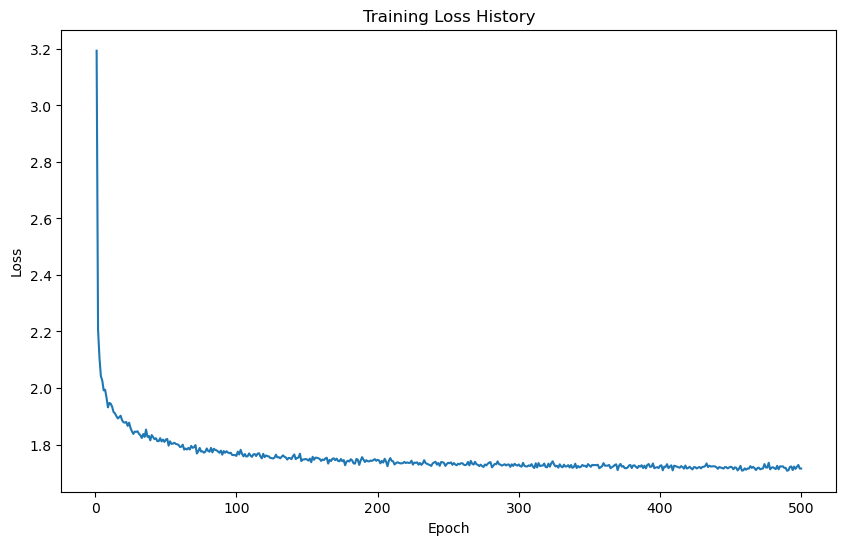

In [46]:
# Plot loss history using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, num_epochs + 1), y=loss_history)
plt.title("Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [47]:
test = pd.read_csv('../data/gridloss/test_backfilled_missing_data.csv')
test['time'] = pd.to_datetime(test['Unnamed: 0'])
test = test[['time', 'grid1-load', 'grid1-loss', 'grid1-temp']]

In [48]:
X_test, y_test = create_training_windows(test, input_columns, target_column, window_size, forecast_horizon)

In [49]:
import torch
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import sample

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on test data and display predictions for 4 random time series instances.

    Parameters:
        model: NN
            Trained neural network model.
        X_test: np.array
            Test input data (shape [samples, features * 24], where each feature has 24 time steps).
        y_test: np.array
            Test target data (time series predictions of shape [samples, 24]).
    """
    # Set model to evaluation mode
    model.eval()

    # Convert test data to PyTorch tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(model.device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(model.device)

    # Disable gradient computation for evaluation
    with torch.no_grad():
        # Get predictions
        outputs = model(X_test_tensor)
        predicted = outputs.cpu().numpy()
        true_values = y_test_tensor.cpu().numpy()

    # Select 4 random test samples to visualize
    indices = sample(range(X_test.shape[0]), 4)

    # Plot predictions vs true values for the selected instances
    fig, axes = plt.subplots(4, 1, figsize=(12, 16))

    for i, ax in enumerate(axes):
        idx = indices[i]
        input_series_feature1 = X_test[idx, :24]  # First 24 entries for feature 1
        input_series_feature2 = X_test[idx, 24:48]  # Next 24 entries for feature 2
        input_series_feature3 = X_test[idx, 48:72]  # Last 24 entries for feature 3

        target_series = true_values[idx]
        predicted_series = predicted[idx]

        ax.plot(range(24), input_series_feature1, label="Feature 1 (Past 24h)", color="blue")
        ax.plot(range(24), input_series_feature2, label="Feature 2 (Past 24h)", color="purple")
        ax.plot(range(24), input_series_feature3, label="Feature 3 (Past 24h)", color="cyan")
        ax.plot(range(24, 48), target_series, label="True Future Series", color="green")
        ax.plot(range(24, 48), predicted_series, label="Predicted Future Series", color="orange", linestyle='dashed')

        ax.set_title(f"Sample {idx} - Time Series Prediction")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend()

    plt.tight_layout()
    plt.show()


In [50]:
X_test.shape

(4281, 72)

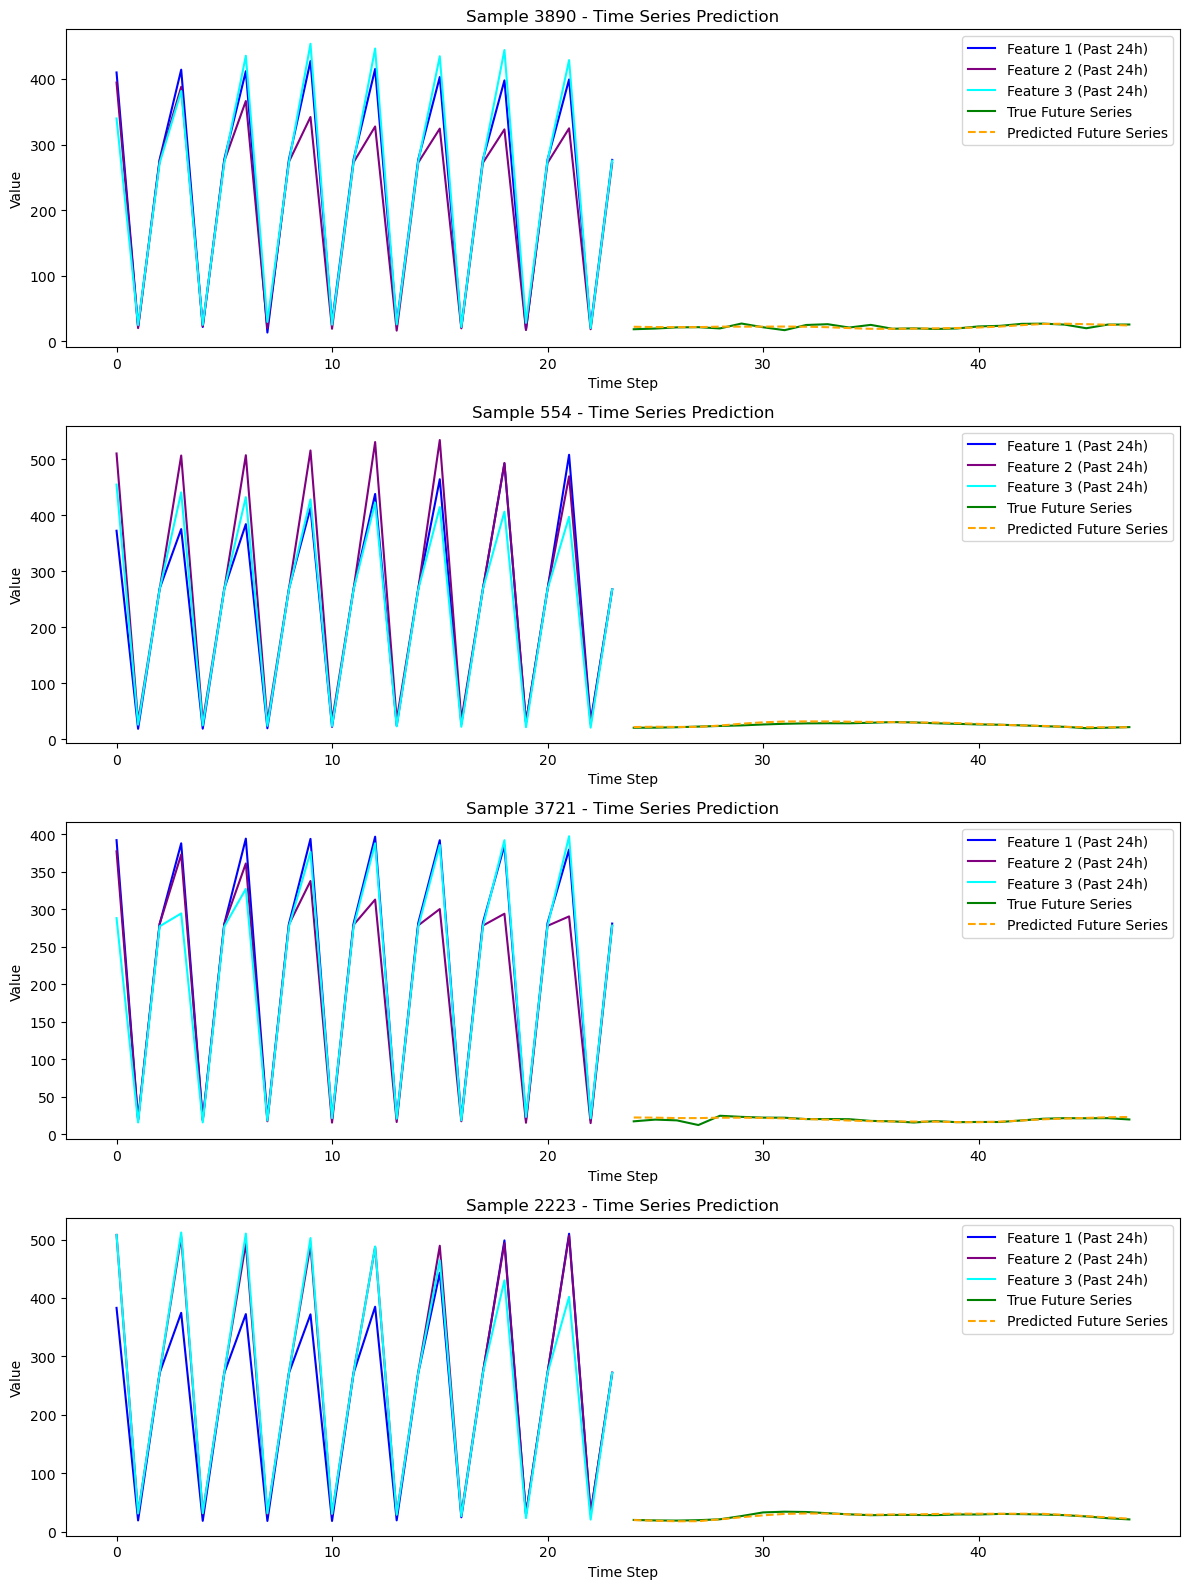

In [51]:
evaluate_model(model, X_test, y_test)

In [52]:
y_test

array([[21.9931 , 21.2879 , 20.9288 , ..., 28.7325 , 25.6306 , 22.2174 ],
       [21.2879 , 20.9288 , 21.1639 , ..., 25.6306 , 22.2174 , 20.497  ],
       [20.9288 , 21.1639 , 22.8061 , ..., 22.2174 , 20.497  , 19.9307 ],
       ...,
       [ 5.84543, 11.4395 ,  8.88915, ...,  8.5598 ,  6.95209,  8.11558],
       [11.4395 ,  8.88915,  7.22653, ...,  6.95209,  8.11558,  7.26431],
       [ 8.88915,  7.22653,  6.98073, ...,  8.11558,  7.26431,  6.78796]])